In [1]:
# https://www.kaggle.com/seshadrikolluri/ansur-ii

# Dataset Link
# https://raw.githubusercontent.com/ingledarshan/upGrad_Darshan/main/ANSUR%20II%20MALE%20Public.csv

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
ansur = pd.read_csv("https://raw.githubusercontent.com/ingledarshan/upGrad_Darshan/main/ANSUR%20II%20FEMALE%20Public.csv")

In [4]:
ansur.head()

,SubjectId,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,bideltoidbreadth,bimalleolarbreadth,bitragionchinarc,bitragionsubmandibulararc,bizygomaticbreadth,buttockcircumference,buttockdepth,buttockheight,buttockkneelength,buttockpopliteallength,calfcircumference,cervicaleheight,chestbreadth,chestcircumference,chestdepth,chestheight,crotchheight,crotchlengthomphalion,crotchlengthposterioromphalion,earbreadth,earlength,earprotrusion,elbowrestheight,eyeheightsitting,footbreadthhorizontal,footlength,forearmcenterofgriplength,forearmcircumferenceflexed,forearmforearmbreadth,...,shouldercircumference,shoulderelbowlength,shoulderlength,sittingheight,sleevelengthspinewrist,sleeveoutseam,span,stature,suprasternaleheight,tenthribheight,thighcircumference,thighclearance,thumbtipreach,tibialheight,tragiontopofhead,trochanterionheight,verticaltrunkcircumferenceusa,waistbacklength,waistbreadth,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,weightkg,wristcircumference,wristheight,Gender,Date,Installation,Component,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference
0,10037,231,1282,301,204,1180,222,177,373,315,263,466,65,338,301,141,1011,223,836,587,476,360,1336,274,922,245,1095,759,557,310,35,65,16,220,713,91,246,316,265,517,...,1062,327,148,803,809,513,1647,1560,1280,1013,622,174,736,430,110,844,1488,406,295,850,217,345,942,657,152,756,Female,5-Oct-10,Fort Hood,Regular Army,Combat Support,92Y,Germany,2,NaN,2,26,61,142,Right hand
1,10038,194,1379,320,207,1292,225,178,372,272,250,430,64,294,270,126,893,186,900,583,483,350,1440,261,839,206,1234,835,549,329,32,60,23,208,726,91,249,341,247,468,...,1014,346,142,835,810,575,1751,1665,1372,1107,524,152,771,475,125,901,1470,422,254,708,168,329,1032,534,155,815,Female,5-Oct-10,Fort Hood,Regular Army,Combat Service Support,25U,California,3,Mexican,3,21,64,120,Right hand
2,10042,183,1369,329,233,1271,237,196,397,300,276,450,69,309,270,128,987,204,861,583,466,384,1451,287,874,223,1226,821,643,374,36,65,26,204,790,100,265,343,262,488,...,1049,362,164,904,855,568,1779,1711,1383,1089,577,164,814,458,129,882,1542,419,269,727,159,367,1035,663,162,799,Female,5-Oct-10,Fort Hood,Regular Army,Combat Service Support,35D,Texas,1,NaN,1,23,68,147,Right hand
3,10043,261,1356,306,214,1250,240,188,384,364,276,484,68,340,294,144,1012,253,897,599,471,372,1430,269,1008,285,1170,804,640,351,38,62,22,244,775,97,265,331,309,529,...,1121,333,157,875,815,536,1708,1660,1358,1065,679,187,736,463,125,866,1627,451,302,923,235,371,999,782,173,818,Female,5-Oct-10,Fort Hood,Regular Army,Combat Service Support,25U,District of Columbia,8,Caribbean Islander,2,22,66,175,Right hand
4,10051,309,1303,308,214,1210,217,182,378,320,336,525,67,300,295,135,1281,284,811,607,467,433,1362,305,1089,290,1112,726,686,356,34,65,18,233,732,88,247,339,260,596,...,1151,329,156,824,810,559,1702,1572,1292,1030,766,197,766,429,116,800,1698,452,405,1163,300,380,911,886,152,762,Female,5-Oct-10,Fort Hood,Regular Army,Combat Arms,42A,Texas,1,NaN,1,45,63,195,Right hand


In [5]:
ansur.shape

(1986, 108)

In [6]:
list(set(ansur.columns) - set(ansur.describe().columns))

['Branch',
 'SubjectsBirthLocation',
 'Date',
 'Ethnicity',
 'Installation',
 'PrimaryMOS',
 'WritingPreference',
 'Gender',
 'Component']

In [7]:
ansur.drop(['Ethnicity',
 'Gender',
 'WritingPreference',
 'Branch',
 'SubjectsBirthLocation',
 'Component',
 'PrimaryMOS',
 'Installation',
 'Date'], axis=1, inplace=True)

In [8]:
list(set(ansur.columns) - set(ansur.describe().columns))

[]

In [9]:
print(ansur.head(2))

   SubjectId  abdominalextensiondepthsitting  ...  Heightin  Weightlbs
0      10037                             231  ...        61        142
1      10038                             194  ...        64        120

[2 rows x 99 columns]


In [10]:
# Feature, target arrays
X, y = ansur.iloc[:, :-1], ansur.iloc[:, -1]

In [11]:
# Train/test set generation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1121218
)

In [12]:
# Scale train and test sets with StandardScaler
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

In [13]:
y_train.shape

(1390,)

In [14]:
# Fix the dimensions of the target array
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [15]:
y_train.shape

(1390, 1)

In [16]:
# Init, fit, test Linear Regressor
from sklearn.linear_model import  LinearRegression
lr = LinearRegression()
lr.fit(X_train_std, y_train)
lr.score(X_test_std, y_test)

0.9277179453047179

We achieved an excellent R-squared of 0.948. We could do this using all 98 features, which is much more than we might need. 

In [17]:
len(X.columns)

98

# Sklearn Recursive Feature Elimination Class

RFE is a transformer estimator, which means it follows the familiar fit/transform pattern of Sklearn. It is a popular algorithm due to its easy configurable nature and robust performance. As the name suggests, it removes features one at a time based on the weights given by a model of our choice in each iteration.

https://www.linkedin.com/pulse/what-recursive-feature-elimination-amit-mittal/


In [18]:
from sklearn.feature_selection import RFE

# Init the transformer
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)

# Fit to the training data
rfe.fit(X_train_std, y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=10, step=1, verbose=0)

After fitting the estimator, it has a .support_ attribute that gives a boolean mask with False values for discarded features. We can use it to subset our data:

In [19]:
X_train.loc[:, rfe.support_]

,buttockkneelength,chestheight,eyeheightsitting,kneeheightmidpatella,kneeheightsitting,sittingheight,suprasternaleheight,tibialheight,waistheightomphalion,weightkg
1473,596,1065,725,420,485,828,1256,401,902,846
1754,579,1171,768,447,510,880,1335,435,1007,644
704,489,1054,722,387,440,841,1201,380,861,488
82,633,1159,763,450,517,872,1360,444,1008,786
1387,583,1175,739,460,511,849,1300,438,959,695
...,...,...,...,...,...,...,...,...,...,...
619,552,1108,781,418,469,888,1270,402,913,564
588,591,1195,769,460,519,880,1350,448,984,619
1419,599,1107,712,427,486,803,1300,417,929,717
1442,645,1174,790,469,540,910,1378,457,980,962


Or you can directly call .transform() to get a new numpy array with the relevant features. Let's use this smaller subset to test Linear Regression once again:

In [20]:
# Init, fit, score
lr = LinearRegression()
_ = lr.fit(rfe.transform(X_train_std), y_train)
lr.score(rfe.transform(X_test_std), y_test)

0.9304381771829048

Even after dropping almost 90 features, we got the same score which is very impressive!

RFE Performance Considerations

Since RFE trains the given model on the full dataset every time it drops a feature, the computation time will be heavy for large datasets with many features as ours. To control this behavior, RFE provides step parameter that lets us drop an arbitrary number of features in each iteration instead of one:


In [21]:
# Init the transformer
rfe = RFE(estimator=LinearRegression(), 
          n_features_to_select=10, step=10)
_ = rfe.fit(X_train_std, y_train)

print(X_train.columns[rfe.support_])

Index(['axillaheight', 'buttockkneelength', 'cervicaleheight', 'crotchheight',
       'eyeheightsitting', 'sittingheight', 'suprasternaleheight',
       'tibialheight', 'waistheightomphalion', 'weightkg'],
      dtype='object')


Choosing the number of features to keep automatically

The most important hyperparameters of RFE are estimator and n_features_to_select. In the last example, we arbitrarily chose 10 features and hoped for the best. However, as RFE can be wrapped around any model, we have to choose the number of relevant features based on their performance.

To achieve this, Sklearn provides a similar RFECV class which implements Recursive Feature Elimination with cross-validation and automatically finds the optimal number of features to keep. 

Below is an example that uses RFECV around a simple Linear Regression. We will be choosing Linear regression because we can guess there will be a linear correlation between body measurements. Besides, combined with cross-validation, Random Forest Regressor will become more computationally expensive:

In [22]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

# Init, fit
rfecv = RFECV(
    estimator=LinearRegression(),
    min_features_to_select=5,
    step=5,
    n_jobs=-1,
    scoring="r2",
    cv=5,
)

_ = rfecv.fit(X_train_std, y_train)

I provided the default values to cv and scoring parameters. A new hyperparameter is min_features_to_select - you can probably guess what it does from the name. Let's see how many features the estimator computed to keep:


In [24]:
X_train.columns[rfecv.support_]

Index(['axillaheight', 'buttockkneelength', 'cervicaleheight', 'chestheight',
       'crotchheight', 'eyeheightsitting', 'sittingheight',
       'suprasternaleheight', 'tibialheight', 'verticaltrunkcircumferenceusa',
       'waistheightomphalion', 'weightkg', 'wristheight'],
      dtype='object')

In [26]:
len(X_train.columns)

98

In [27]:
len(X_train.columns[rfecv.support_])

13

RFECV tells us to keep only 13 out of 98. Let's train the model only on those 5 and look at its performance:

In [28]:
lr = LinearRegression()
_ = lr.fit(X_train_std, y_train)

print("Trainign R-sqaured:", lr.score(X_train_std, y_train))
print("Testing R-squared:",lr.score(X_test_std, y_test))

Trainign R-sqaured: 0.9531432571534393
Testing R-squared: 0.9277179453047179


Even after dropping 93 features, we still got an impressive score of 0.956.

# Variance Inflation Factor

https://online.stat.psu.edu/stat462/node/180/

https://statisticsbyjim.com/regression/variance-inflation-factors/

Dataset Link:

https://raw.githubusercontent.com/ingledarshan/upGrad_Darshan/main/BMI.csv

# Detecting Multicollinearity with VIF – Python

Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated, we might have difficulty in distinguishing between their individual effects on the dependent variable. Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor(VIF).

In VIF method, we pick each feature and regress it against all of the other features. For each regression, the factor is calculated as :



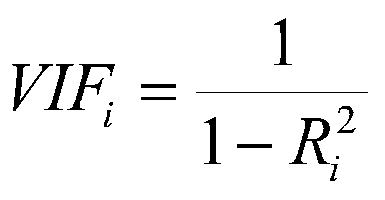

Where, R-squared is the coefficient of determination in linear regression. Its value lies between 0 and 1.

As we see from the formula, greater the value of R-squared, greater is the VIF. Hence, greater VIF denotes greater correlation. This is in agreement with the fact that a higher R-squared value denotes a stronger collinearity. Generally, a VIF above 5 indicates a high multicollinearity. 

# Implementing VIF using statsmodels:

statsmodels provides a function named variance_inflation_factor() for calculating VIF.

Syntax : 

statsmodels.stats.outliers_influence.variance_inflation_factor(exog, exog_idx)

Parameters :

exog : an array containing features on which linear regression is performed.
exog_idx : index of the additional feature whose influence on the other features is to be measured.

The dataset used in the example below, contains the height, weight, gender and Body Mass Index for 500 persons. Here the dependent variable is Index. 

In [29]:
import pandas as pd 
  
# the dataset
data = pd.read_csv('https://raw.githubusercontent.com/ingledarshan/upGrad_Darshan/main/BMI.csv')

In [30]:
# printing first few rows
print(data.head())

   Gender  Height  Weight  Index
0    Male     174      96      4
1    Male     189      87      2
2  Female     185     110      4
3  Female     195     104      3
4    Male     149      61      3


# Approach :

Each of the feature indices are passed to variance_inflation_factor() to find the corresponding VIF.

These values are stored in the form of a Pandas DataFrame.

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# creating dummies for gender
data['Gender'] = data['Gender'].map({'Male':0, 'Female':1})
data.head()

,Gender,Height,Weight,Index
0,0,174,96,4
1,0,189,87,2
2,1,185,110,4
3,1,195,104,3
4,0,149,61,3


In [32]:
# the independent variables set
X = data[['Gender', 'Height', 'Weight']]

In [33]:
X.head()

,Gender,Height,Weight
0,0,174,96
1,0,189,87
2,1,185,110
3,1,195,104
4,0,149,61


In [34]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data

,feature
0,Gender
1,Height
2,Weight


In [35]:
len(X.columns)

3

In [36]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

  feature        VIF
0  Gender   2.028864
1  Height  11.623103
2  Weight  10.688377


As we can see, height and weight have very high values of VIF, indicating that these two variables are highly correlated. This is expected as the height of a person does influence their weight. Hence, considering these two features together leads to a model with high multicollinearity.

# Final Compilation:

**https://www.listendata.com/2018/01/linear-regression-in-python.html**

# Happy Learning